# Fake News Detection on Social Media

**Course Code:** CM3070  
**Course Name:** Final Project  
**Template:** Fake News Detection (Natural Language Processing (NLP))  

# Table of Content

- [Importing Dataset](#Importing-Dataset)
- [Data Preprocessing](#Data-Preprocessing)
- [Feature Extraction](#Feature-Extraction)
- [Exploratory Data Analysis(EDA)](#Exploratory-Data-Analysis(EDA))
- [Model Building](#Model-Building)
- [Performance-Evaluation](#Performance-Evaluation)

# Importing Dataset

In [1]:
import pandas as pd
import numpy as np
import os

data_path = os.path.join(os.getcwd(), 'Resources', 'LIAR', 'train.tsv')
# Load data with appropriate column name
col_name = ["id", "label", "text", "subject", "author", "author_job", "location", "political_inclination",
            "bt_count", "false_count", "ht_count", "mt_count", "pf_count", "context"]

data = pd.read_csv(data_path, sep='\t', names = col_name)
data.text = data.subject + " " + data.text
data = data[["text", "label"]]

# Map data into two categories: FAKE and REAL
mapper = {  "half-true" :     1,
            "false"      :    0,
            "mostly-true" :   1,
            "true"         :  1,
            "barely-true"  :  0,
            "pants-fire" :    0
         }

data["new_label"] = data.label.replace(mapper)
data.dropna(inplace = True)

In [2]:
data.head()

,text,label,new_label
0,abortion Says the Annies List political group ...,false,0
1,"energy,history,job-accomplishments When did th...",half-true,1
2,foreign-policy Hillary Clinton agrees with Joh...,mostly-true,1
3,health-care Health care reform legislation is ...,false,0
4,"economy,jobs The economic turnaround started a...",half-true,1


# Data Preprocessing

In [3]:
# Importing custom build functions
from FakeNewsProcessor.preprocessor import *

[nltk_data] Downloading package stopwords to C:\Users\Akshay
[nltk_data]     Lad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Akshay
[nltk_data]     Lad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Akshay
[nltk_data]     Lad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Akshay Lad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
new_data = preprocess(data,"text")

Data cleaned
Data stopwords removed
Data lemmatized


# Feature Extraction

In [5]:
new_data = text_features(new_data)

In [6]:
new_data.head()

,text,label,new_label,cleaned_text,sent_length,word_count,pos_count,neg_count
0,abortion Says the Annies List political group ...,false,0,abortion say annies list political group suppo...,80,11,2,0
1,"energy,history,job-accomplishments When did th...",half-true,1,energy history job accomplishment decline coal...,126,18,8,1
2,foreign-policy Hillary Clinton agrees with Joh...,mostly-true,1,foreign policy hillary clinton agrees john mcc...,92,14,2,1
3,health-care Health care reform legislation is ...,false,0,health care health care reform legislation lik...,81,12,7,0
4,"economy,jobs The economic turnaround started a...",half-true,1,economy job economic turnaround start end term,46,7,2,0


## 1. Spliting data as training and Test (Validation)

In [7]:
from sklearn.model_selection import train_test_split

feature_selection = ['cleaned_text','sent_length', 'word_count', 'pos_count', 'neg_count']
# feature_selection = ['cleaned_text']

X_train, X_test, y_train, y_test = train_test_split(new_data[feature_selection], new_data['new_label'], test_size=0.3, random_state=0)

# Checking size of training and test data
print('Training data sample size: ', X_train.shape[0])
print('Testing data sample size: ', X_test.shape[0])

Training data sample size:  7166
Testing data sample size:  3072


## 2. Text Vectorization

In [8]:
# Import TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# Initailise TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features = 15000, min_df= 8)
train = tfidf.fit_transform(X_train['cleaned_text'])
test = tfidf.transform(X_test['cleaned_text'])

In [9]:
print('Training Features size: ', train.shape)
print('Testing Features size: ', test.shape)

Training Features size:  (7166, 1546)
Testing Features size:  (3072, 1546)


### 2.1. Adding Numerical Features to Text Vector

In [10]:
def add_numerical_features(text_features, num_feature):
    feature_array = np.concatenate((text_features.toarray(), np.array(num_feature)[:,None]), axis = 1)
    return csr_matrix(feature_array)

In [11]:
for feature in ['sent_length','word_count','pos_count','neg_count']:
    train = add_numerical_features(train, X_train[feature])
    test = add_numerical_features(test, X_test[feature])

print('Training New Features size: ', train.shape)
print('Testing New Features size: ', test.shape)

Training New Features size:  (7166, 1550)
Testing New Features size:  (3072, 1550)


# Exploratory Data Analysis(EDA)

In [12]:
# Importing custom build functions
from FakeNewsProcessor.data_analysis import *

In [13]:
# Build datapoints to plot

# Split dataset for fake and real news
fake = new_data[new_data['new_label'] == 0]
real = new_data[new_data['new_label'] == 1]

# Calculate Length of string for each news document
fake_sent_len = [len(x) for x in fake.cleaned_text]
real_sent_len = [len(x) for x in real.cleaned_text]

# Calculate word count for each news document
fake_word_count = [len(nltk.word_tokenize(x)) for x in fake.cleaned_text]
real_word_count = [len(nltk.word_tokenize(x)) for x in real.cleaned_text]

# Sentiment (Tone) of fake news document
fake['sentiment'] = (fake.pos_count - fake.neg_count)
fake['sentiment'] = np.where(fake['sentiment'] > 0, "Positive", "Negative")

# Sentiment (Tone) of fake news document
real['sentiment'] = (real.pos_count - real.neg_count)
real['sentiment'] = np.where(real['sentiment'] > 0, "Positive", "Negative")

<ipython-input-13-0fa3f7ffdfd0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake['sentiment'] = (fake.pos_count - fake.neg_count)
<ipython-input-13-0fa3f7ffdfd0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake['sentiment'] = np.where(fake['sentiment'] > 0, "Positive", "Negative")
<ipython-input-13-0fa3f7ffdfd0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

### 1. Sentence Length and Word Count distribution for Fake & Real News

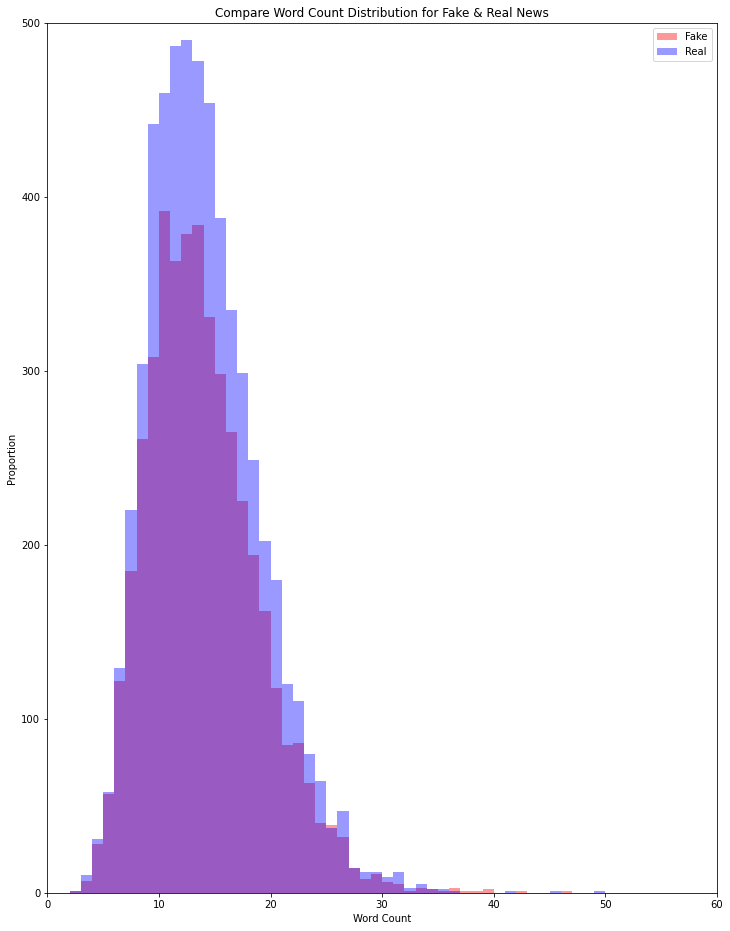

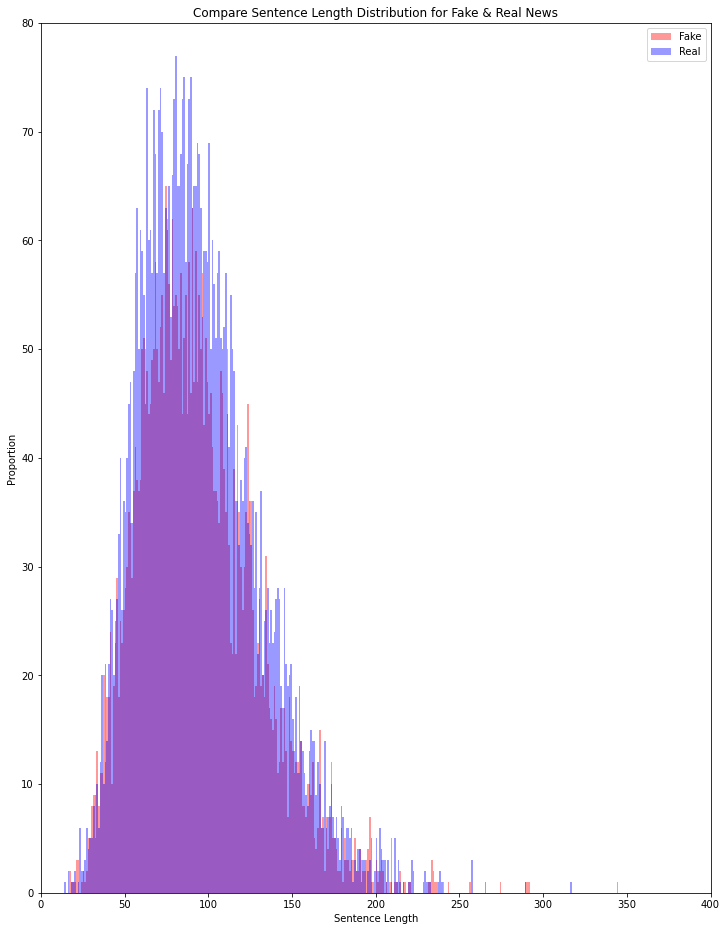

In [14]:
plot_histogram(fake_word_count, real_word_count, [0,60,0,500], plot_title="Compare Word Count Distribution for Fake & Real News", x_label= "Word Count")
plot_histogram(fake_sent_len, real_sent_len, [0,400,0,80], plot_title="Compare Sentence Length Distribution for Fake & Real News", x_label= "Sentence Length")

### 2. WordCloud for Fake & Real News

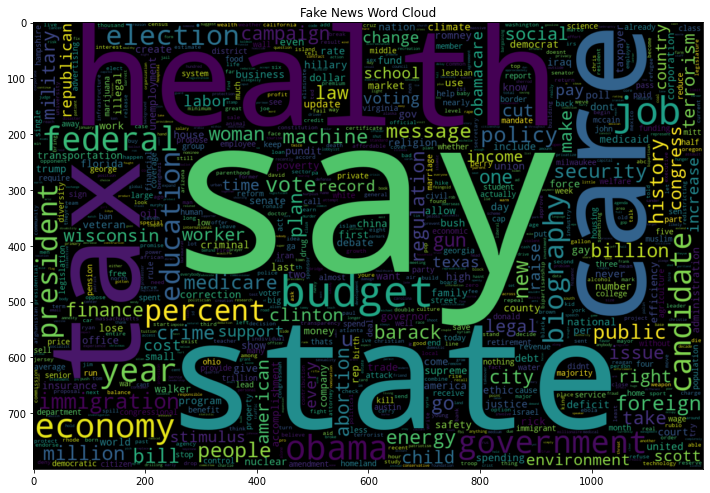

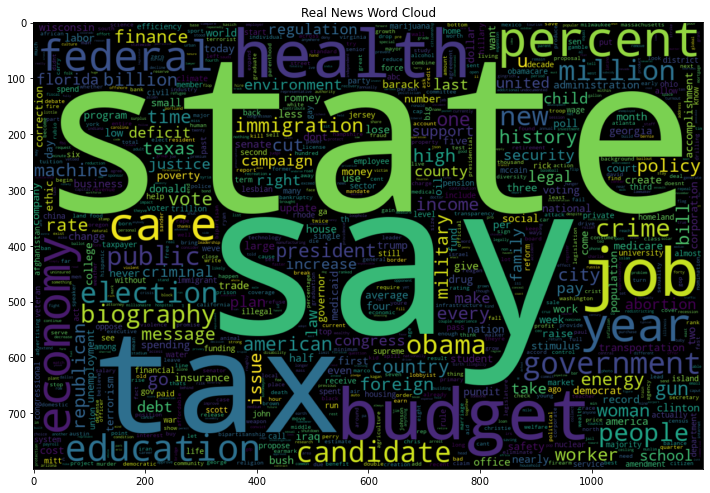

In [15]:
word_cloud_plot(fake.cleaned_text, "Fake News Word Cloud")
word_cloud_plot(real.cleaned_text, "Real News Word Cloud")

### 3. Tone of News (Positive or Negative)

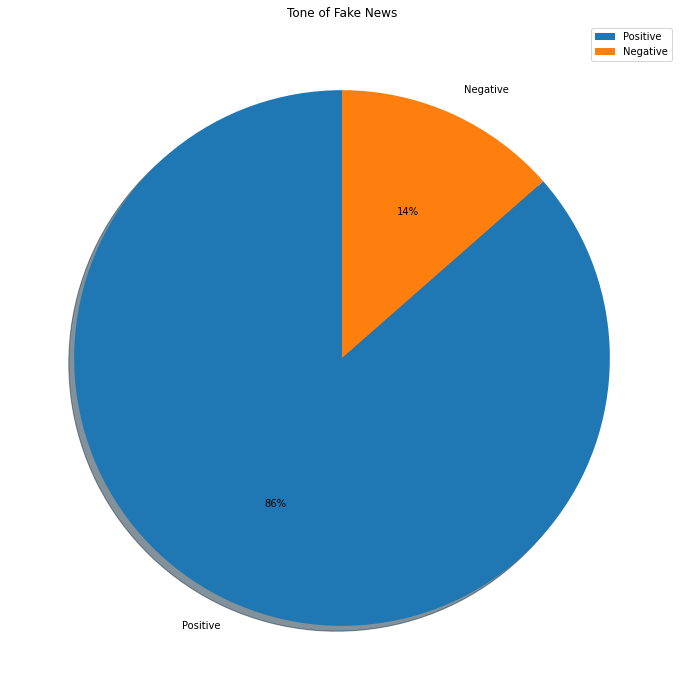

In [16]:
plt.figure(figsize = (12,16)) 

plt.pie(fake.sentiment.value_counts(), labels = ['Positive', 'Negative'], startangle = 90, shadow = True, autopct='%1.0f%%')
plt.title("Tone of Fake News")
plt.legend()

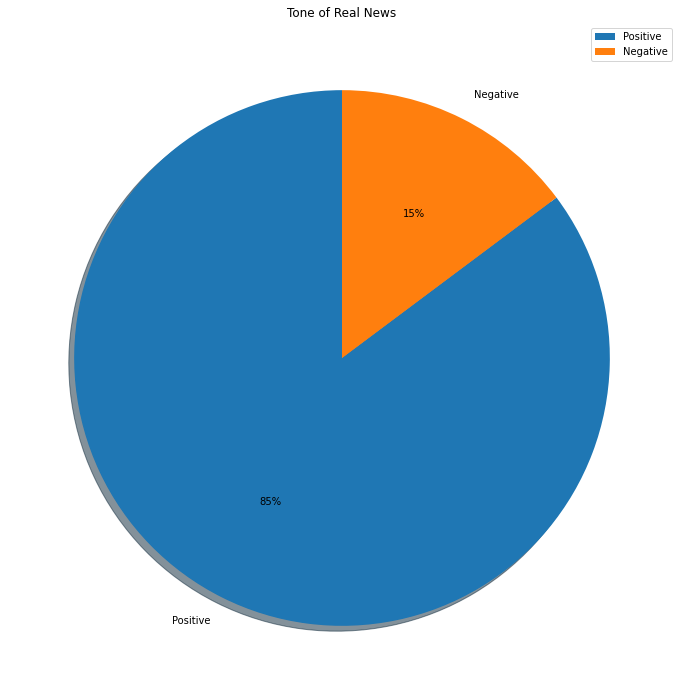

In [17]:
plt.figure(figsize = (12,16)) 
plt.pie(real.sentiment.value_counts(), labels = ['Positive', 'Negative'], startangle = 90, shadow = True, autopct='%1.0f%%')
plt.title("Tone of Real News")
plt.legend()

# Model Building

In [19]:
# Importing metrics and model libraries requied to train and test model
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

# To plot graphs
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_cm(plt, conf_matrix, title):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix: ' + title, fontsize=18)
    
    plt.show()
    
def evaluate_model(model, train, test, train_out, test_out):
    
    model_info = {
                    "Model": None,
                    "Accuracy": None,
                    "Precision": None,
                    "Recall": None,
                    "F1 Score": None
                }
    
    model.fit(train, train_out)
    
    prediction = model.predict(test)
    try:
        predict_prob = model.predict_proba(test)
    except:
        print("prod cannot happen")
        predict_prob = None
    
    model_info['Model'] = str(model).split('(')[0]
    model_info['Accuracy'] = round(accuracy_score(test_out,prediction),3)
    model_info['Recall'] = round(recall_score(test_out,prediction),3)
    model_info['Precision']= round(precision_score(test_out,prediction),3)
    model_info['F1 Score'] = round(f1_score(test_out,prediction),3)
    
    cf_mat = confusion_matrix(y_true=y_test, y_pred=prediction)
    plot_cm(plt, cf_mat, title = model_info['Model'])
    
    return model, predict_prob, model_info

## 1. Model Initialization

In [20]:
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Training Models
mnb = MultinomialNB(alpha=0.5)
knn = KNeighborsClassifier()
lr = LogisticRegression(penalty='l2', solver = 'liblinear')
xgb = XGBClassifier()
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)

# Voting Classifier
voting_soft = VotingClassifier(estimators=[('MultiNomialNB', mnb), 
                                      ('Logistic_Regression', lr),  
                                      ('RandomForest', rfc)], voting='soft')
 
 

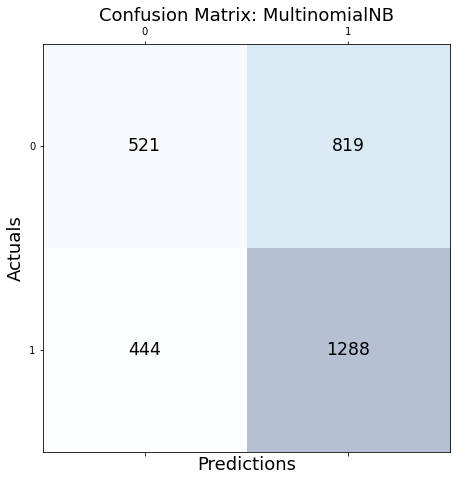

{'Model': 'MultinomialNB', 'Accuracy': 0.589, 'Precision': 0.611, 'Recall': 0.744, 'F1 Score': 0.671}


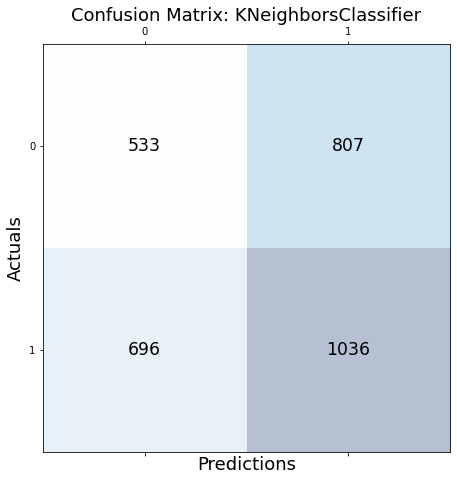

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.511, 'Precision': 0.562, 'Recall': 0.598, 'F1 Score': 0.58}


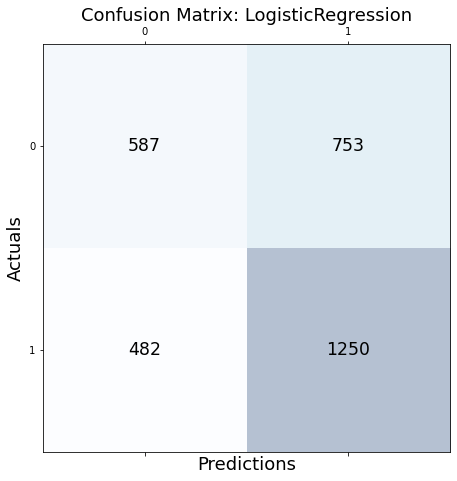

{'Model': 'LogisticRegression', 'Accuracy': 0.598, 'Precision': 0.624, 'Recall': 0.722, 'F1 Score': 0.669}
[03:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Akshay Lad\UniOLondon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


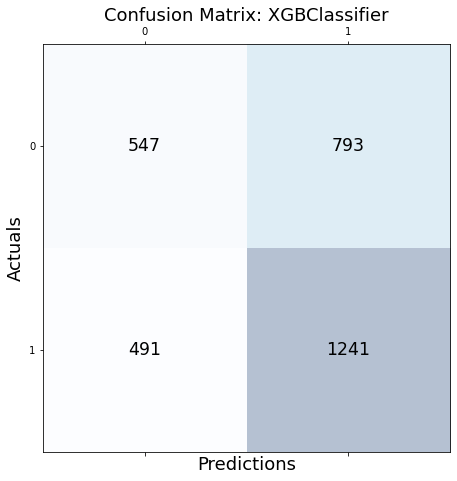

{'Model': 'XGBClassifier', 'Accuracy': 0.582, 'Precision': 0.61, 'Recall': 0.717, 'F1 Score': 0.659}


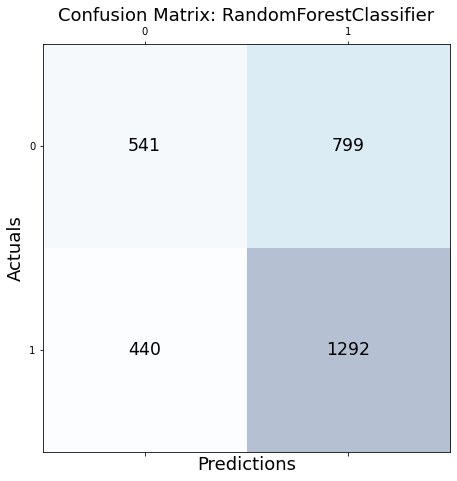

{'Model': 'RandomForestClassifier', 'Accuracy': 0.597, 'Precision': 0.618, 'Recall': 0.746, 'F1 Score': 0.676}


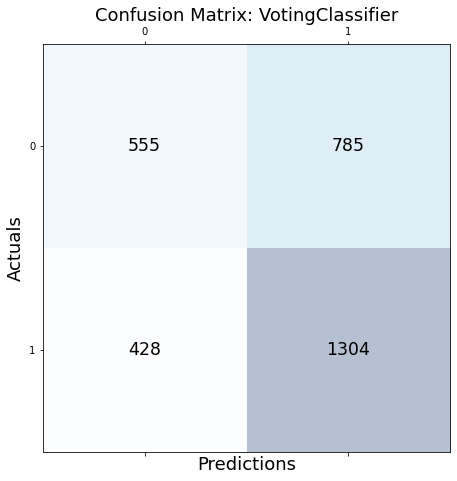

{'Model': 'VotingClassifier', 'Accuracy': 0.605, 'Precision': 0.624, 'Recall': 0.753, 'F1 Score': 0.683}


In [21]:
model_list = [mnb,knn,lr,xgb,rfc, voting_soft]

model_eval = []
classfiers_list = []

for model in model_list:
    classfier, predic_probs, model_info = evaluate_model(model, train, test, y_train, y_test)
    print(model_info)
    model_eval.append(model_info)
    classfiers_list.append(classfier)
    

# Performance-Evaluation

In [43]:
pd.DataFrame(model_eval).sort_values(by=['Accuracy','F1 Score','Precision'], ascending=False) 

,Model,Accuracy,Precision,Recall,F1 Score
5,VotingClassifier,0.603,0.621,0.756,0.682
2,LogisticRegression,0.598,0.624,0.722,0.669
4,RandomForestClassifier,0.597,0.618,0.746,0.676
0,MultinomialNB,0.592,0.610,0.764,0.678
3,XGBClassifier,0.582,0.610,0.717,0.659
1,KNeighborsClassifier,0.511,0.562,0.598,0.580
